In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import animation
from scipy.stats import norm
from cmath import sqrt
from time import time
π = np.pi
num_points = 500
tol = 1e-14

In [2]:
%matplotlib inline
plt.rcParams["figure.dpi"] = 300

In [3]:
def f(func,C) :
    '''
    If C = UΣU.T, then f(C) = Uf(Σ)U.T = U*diag(func(σ_1),...,func(σ_2))*U.T
    
    Inputs :
        func - Callable scalar function
        C    - Cross Spectral Matrix of a system
        
    Output :
        f(C) as defined in description
    '''
    eigv, U = np.linalg.eig(C)
    eigv = [0 if val < tol else val for val in eigv]
    f_eigs = [func(eig) for eig in eigv]
    return U@np.diag(f_eigs)@U.T

def weights(θ,N,r,λ) :
    '''
    Calculates the coefficients of the beam equation
    
    Inputs:
        θ (rad) - angle off from orthogonal to array
        N (int) - number of antenna +1
    
    Output:
        a_k for the beam form equation Σ_1^N <a_k(θ), x_k>; x_k is the volatge response of antenna k
        NOTE: This vector is normalized (why? I don't know)
    '''
    ϕ = π*np.sin(θ)
    bs = np.zeros(N).astype(complex)
    for k in range(N) :
        bs[k] = np.exp(ϕ*k*1j)
    return bs/np.linalg.norm(bs)

def calc_sinr_ber(signal_beam,noise_beams,var_awgn=1,var_ray=1,dist_fad_exp=None,verbose=True,h_sig=None) :
    '''
    Calculates the estimated SINR and BER for certain locations based on transmission beams.
    
    Input :
        Beams are of the form [power_levels (n,) array, weights (L,) array]
        signal_beam - beam  - The signal beam
        noise_beams - list  - List of noise beams (each beam like signal beam)
        var_awgn    - float - White noise variance
        var_ray     - float - Fading variance of the Rayleigh channel
        
    Output :
        SINR - (n,n) array  - Signal to Interference and Noise Ratio
        BER  - (n,n) array  - Bit Error Rate (for BPSK under https://www.unilim.fr/pages_perso/vahid/notes/ber_awgn.pdf)
    '''
    sig_beam = signal_beam[0]
    sig_weights = signal_beam[1]
    n_beams = [beam[0] for beam in noise_beams]
    n_weights = [beam[1] for beam in noise_beams]
    K = len(n_weights)
    n = len(sig_beam)
    L = sig_weights.shape[0]
    r = np.linspace(tol,max(sig_beam),n)
    SINR = np.zeros((n,n)).astype(complex)
    if h_sig is None :
        h_sig = np.random.normal(loc=np.array([0,0]),scale=np.array([var_ray,var_ray]),size=(L,2))
        h_sig = 1/sqrt(2)*(h_sig[:,0] + 1j*h_sig[:,1])
    sig_const = abs(h_sig @ sig_weights)**2
    noise_const = [abs(h_sig[i] @ weight[i])**2 for i in range(K)]
    for j in range(n) : # Iterating over θ
        sig_pow = abs(sig_beam[j])
        noise_pows = [beam[j] for beam in n_beams]
        if dist_fad_exp :
            SINR[j,:] = [((sig_pow/(r[i]**dist_fad_exp))*sig_const)/(var_awgn + sum([(noise_pows[k]/(r[i]**dist_fad_exp))*noise_const[k] for k in range(K)])) for i in range(n)]
        else :
            SINR[j,:] = [(sig_pow*sig_const)/(var_awgn + sum([noise_pows[k]*noise_const[k] for k in range(K)])) for i in range(n)]
        if verbose and (j+1) % 100 == 0 :
            print(f'{j+1}th iteration complete.')
    SINR = np.abs(SINR).astype(float)
    mask = SINR >= max(sig_beam)
    SINR[mask] = max(sig_beam)
    BER = 1 - norm.cdf(np.sqrt(2*SINR*abs(h_sig @ h_sig)))
    SINR = 10*np.log(SINR)/np.log(10)
    return SINR, BER

### For a single beam

In [4]:
N = 7                                                 # Number of antenna
λ = 1                                                 # Wavelength
ν = 3                                                 # Functional Beamforming Exponent
σ2_awgn = 1                                           # Noise/AWGN variance
σ2_ray = 1                                            # Noise/Fading variance
beams = 2*π/7                                         # Desired azmith angle
s_k = 10                                              # Alice's signal strength
θs = np.linspace(0,2*π,num_points)
ak = weights(beams,N,s_k,λ)
g_k = np.array(ak).reshape(1,N)                       # Direction of Alice's transmitter relative to Bob (in this case, beam_θ)
C = (np.dot(np.conj(g_k.T),g_k))                               # Cross Spectral Matrix
func = lambda x : x**(1/ν)
b = lambda g : abs(np.conj(g.T)@f(func,C)@g)**ν
sig_beam = [b(weights(θ,N,s_k,λ)) for θ in θs]
signal_beam = [sig_beam,ak]

In [5]:
start = time()
SINR, BER = calc_sinr_ber(signal_beam,[],var_awgn=σ2_awgn,var_ray=σ2_ray,dist_fad_exp=2)
end = time()
print(f'Took {(end-start)//3600} hour(s), {((end-start)%3600)//60} minute(s) and {(((end-start)%3600)%60)} seconds.')

100th iteration complete.
200th iteration complete.
300th iteration complete.
400th iteration complete.
500th iteration complete.
Took 0.0 hour(s), 0.0 minute(s) and 0.3398420810699463 seconds.


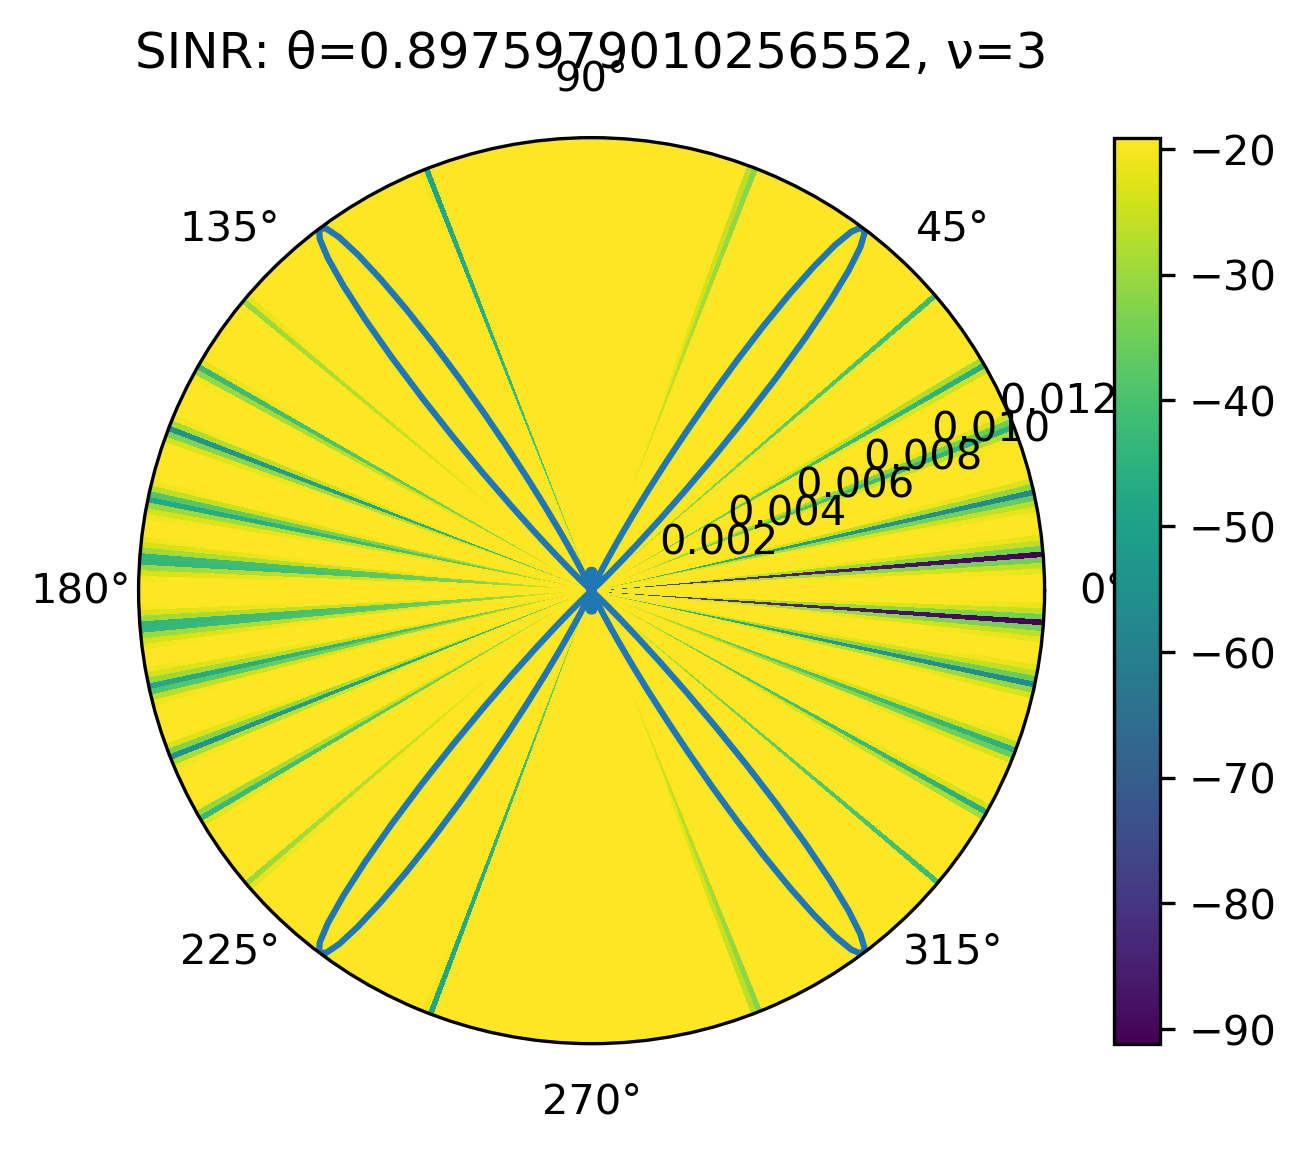

In [6]:
θ = np.linspace(0,2*π,num_points)
r = np.linspace(0,max(sig_beam),num_points)
R,Θ = np.meshgrid(r,θ)
plt.polar(θ,sig_beam)
plt.pcolor(Θ,R,SINR)
plt.colorbar()
plt.title(f'SINR: θ={beams}, ν={ν}')
plt.show()

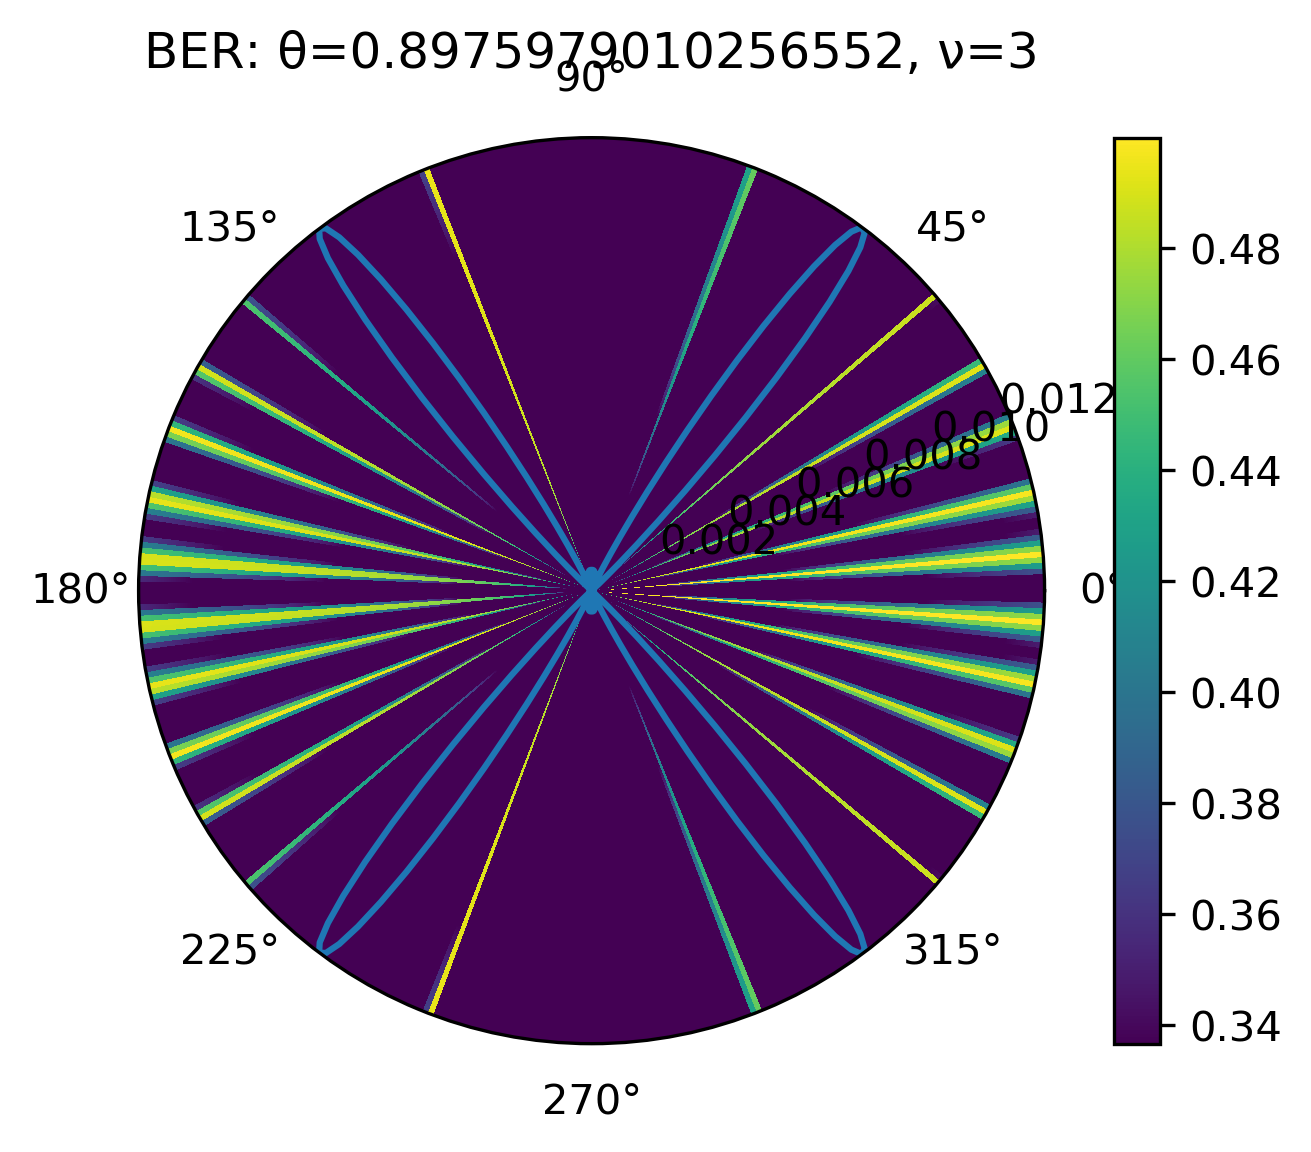

In [7]:
plt.polar(θ,sig_beam)
plt.pcolor(Θ,R,BER)
plt.colorbar()
plt.title(f'BER: θ={beams}, ν={ν}')
plt.show()

### Moving the beam

In [11]:
N = 7                                                 # Number of antenna
λ = 1                                                 # Wavelength
ν = 3                                                 # Functional Beamforming Exponent
σ2_awgn = 1                                           # Noise/AWGN variance
σ2_ray = 1                                            # Noise/Fading variance
beam_cent = 2*π/7                                     # Azmith angle to Bob
num_packets = 51
beams = np.linspace(beam_cent-π/12,beam_cent+π/12,num_packets)
s_k = 10                                              # Alice's signal strength
func = lambda x : x**(1/ν)
θs = np.linspace(0,2*π,num_points)
all_beams = []
SINRs = np.zeros((num_points,num_points,num_packets))
BERS = np.zeros((num_points,num_points,num_packets))
hsig = np.random.normal(loc=np.array([0,0]),scale=np.array([σ2_ray,σ2_ray]),size=(N,2))
hsig = 1/sqrt(2)*(hsig[:,0] + 1j*hsig[:,1])
start = time()
for i in range(num_packets) :
    ak = weights(beams[i],N,s_k,λ)
    g_k = np.array(ak).reshape(1,N)                   # Direction of Alice's transmitter relative to Bob (in this case, beam_θ)
    C = (np.dot(g_k.T,g_k))                           # Cross Spectral Matrix
    b = lambda g : (g.T@f(func,C)@g)**ν
    sig_beam = [b(weights(θ,N,s_k,λ)) for θ in θs]
    all_beams.append(sig_beam)
    signal_beam = [sig_beam,ak]
    SINRs[:,:,i], BERS[:,:,i] = calc_sinr_ber(signal_beam,[],var_awgn=σ2_awgn,var_ray=σ2_ray,dist_fad_exp=2,verbose=False,h_sig=hsig)
end = time()
all_beams = np.array(all_beams)
print(f'Took {(end-start)//3600} hour(s), {((end-start)%3600)//60} minute(s) and {(((end-start)%3600)%60)} seconds.')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: ComplexWarning: Casting complex values to real discards the imaginary part


Took 0.0 hour(s), 0.0 minute(s) and 24.192848920822144 seconds.


In [12]:
np.save('../../../IRES_Files/Beams_fun_complex',all_beams)
np.save('../../../IRES_Files/SINRs_fun_complex',SINRs)
np.save('../../../IRES_Files/BERS_fun_complex',BERS)

In [13]:
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


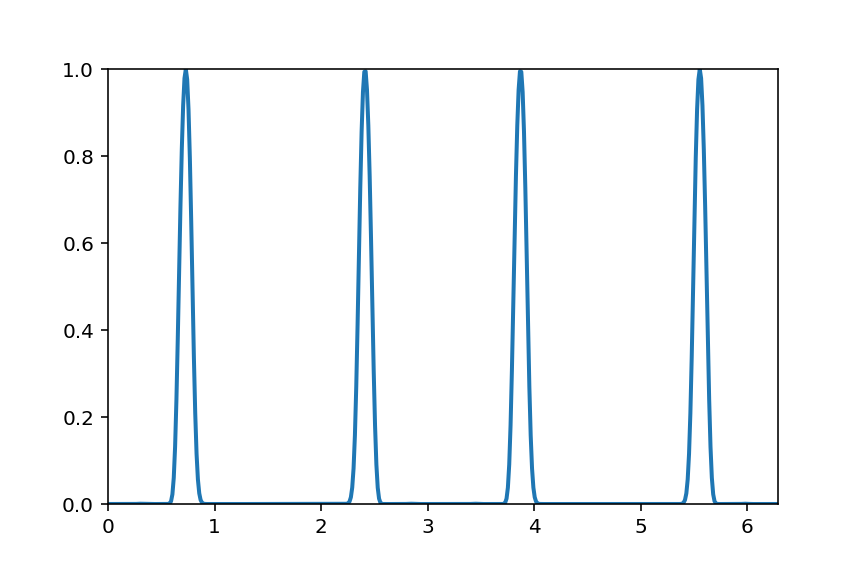

In [14]:
"""
https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
"""

# Initialize values
fig = plt.figure()
ax = plt.axes(xlim=(0,2*π),ylim=(0,1))
beam, = ax.plot([],[],lw=2)

# Define constructor fucntion
def constructor() :
    beam.set_data([],[])
    return beam,

# Define animation function
def animating(i) :
    θ = np.linspace(0,2*π,num_points)
    r = all_beams[i,:]
    beam.set_data(θ,r)
    return beam,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animating, init_func=constructor,frames=num_packets, interval=20, blit=True)
# Something's wrong with the save...
#anim.save('../../../IRES_Files/Animations/Fun_beam_complex.html', fps=30, extra_args=['-vcodec', 'libx264'])
#plt.show()

<IPython.core.display.Javascript object>


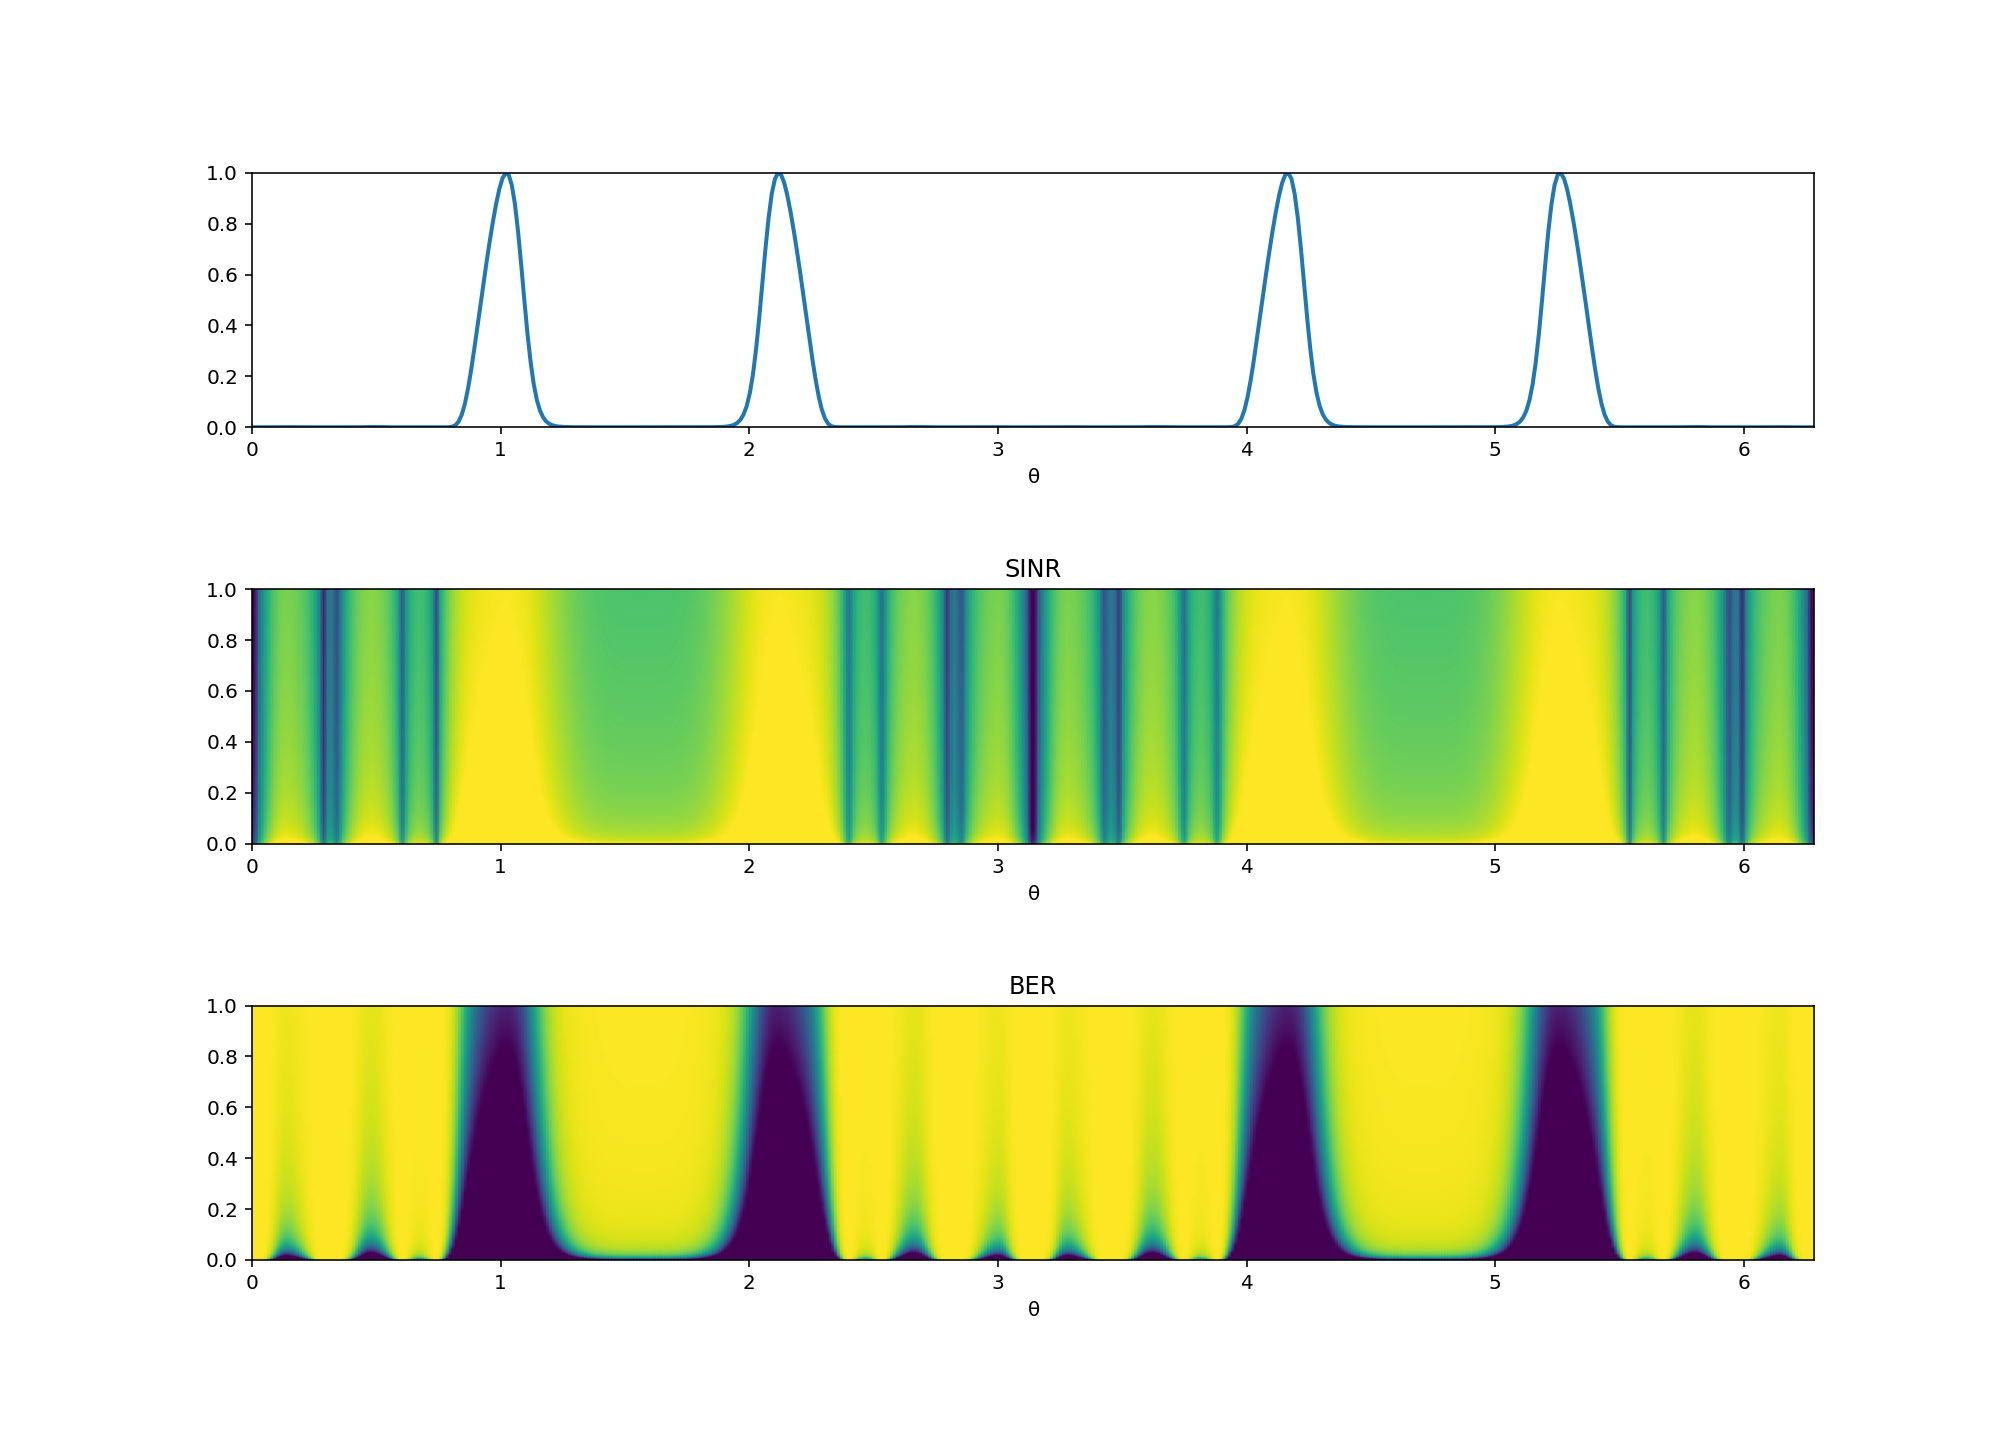

In [16]:
%matplotlib notebook
# Initialize values
fig = plt.figure(figsize=(14,10), facecolor='white')
gs = gridspec.GridSpec(8,1)

ax1 = plt.subplot(gs[:2,:])
ax1.set_xlim(0,2*π)
ax1.set_ylim(0,1)
ax1.set_xlabel('θ')
ax1.set_title(f'Beam from {beam_cent-π/12} to {beam_cent+π/12}')
beam, = ax1.plot([],[],lw=2)

R, Θ = np.meshgrid(np.linspace(0,1,num_points),np.linspace(0,2*π,num_points))
SNR = SINRs[:,:,0]
ax2 = plt.subplot(gs[3:5,:])
ax2.set_xlim(0,2*π)
ax2.set_ylim(0,1)
ax2.set_xlabel('θ')
ax2.set_title(f'SINR')
snr = ax2.pcolormesh(Θ,R,SNR,shading='gouraud')

BER = BERS[:,:,0]
ax3 = plt.subplot(gs[6:,:])
ax3.set_xlim(0,2*π)
ax3.set_ylim(0,1)
ax3.set_xlabel('θ')
ax3.set_title(f'BER')
ber = ax3.pcolormesh(Θ,R,BER,shading='gouraud')

# Define constructor fucntion
def constructor() :
    beam.set_data([],[])
    snr.set_array(np.array([]))
    ber.set_array(np.array([]))
    return beam,snr,ber

# Define animation function
def animating(i) :
    θ = np.linspace(0,2*π,num_points)
    r = all_beams[i,:]
    beam.set_data(θ,r)
    snr.set_array(SINRs[:,:,i].ravel())
    ber.set_array(BERS[:,:,i].ravel())
    return beam,snr,ber

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animating, init_func=constructor,frames=num_packets, interval=20, blit=True)
# Something's wrong with the save...
#anim.save('../../../IRES_Files/Animations/fun_beam&snr_complex.html', fps=30, extra_args=['-vcodec', 'libx264'])
#plt.show()

In [35]:
print(SINR)

[[-21.58093347          nan          nan ...          nan          nan
           nan]
 [-21.58093347          nan          nan ...          nan          nan
           nan]
 [-21.58093347          nan          nan ...          nan          nan
           nan]
 ...
 [-21.58093347          nan          nan ...          nan          nan
           nan]
 [-21.58093347          nan          nan ...          nan          nan
           nan]
 [-21.58093347          nan          nan ...          nan          nan
           nan]]
